In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import os
import imutils
from PIL import Image
import pytesseract
import scipy.signal
import math as m
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
from num_separate import preprocess,lineSegment,wordSegment
from s_extract import check_extraction,delete_line
def implt(img, cmp=None, t=''):
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

True

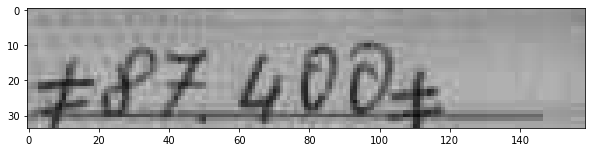

In [354]:
img=cv2.imread(r"C:/Users/Obertys/Desktop/OCR_cheques/cheques/cheque18.jpg")
im=check_extraction(img)[0]
#im=delete_line(im) #zone 0:mtc, 1:mtl1, 2:mtl2, 3:date, 4:nom, 5:sign, 6:lieu
plt.imshow(im)
cv2.imwrite('mont.png',im)

In [355]:
def bilateral_norm(img):
    img = cv2.bilateralFilter(img, 9, 15, 30)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
def histogram_norm(img):
    img = bilateral_norm(img)
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # Filtrage en image dont les pixels de premier plan sont blancs
    img = 255 - img #filtrage en noir 
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255  # normalisation      
    hist, bins = np.histogram(img.ravel(), 256, [0,256]) # img.ravel pour transformer l'image en un vecteur
                                                         #  
    img = img.astype(np.uint8) # 

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)
def cropp(img):
    h,w = img.shape
    top=0
    down=0
    left=0
    right=0
    
    halt = False
    for i in range(h):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                top = i-1
                break
                
    halt = False
    for i in reversed(range(h)):
        if halt:
            break
        for j in range(w):
            if img[i,j] == 0:
                halt = True
                down = i+1
                break
    
    halt = False
    for i in range(w):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                left = i-1
                break
                
    halt = False
    for i in reversed(range(w)):
        if halt:
            break
        for j in range(h):
            if img[j,i] == 0:
                halt = True
                right = i+1
                break
                
    if (top < 0): top = 0
    if (down < 0): down = 0
    if (left < 0): left = 0
    if (right < 0): right = 0
        
    #print('Top: ', top)
    #print('Down: ', down)
    #print('Left: ', left)
    #print('Right: ', right)
    
    return img[top:down, left:right]
def segment(img, height, width, indexes):
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    print("svee: ", indexes)
    for i in range(len(indexes)-1):
        width = indexes[i+1] - indexes[i]
        if width >45: # paramètre de réglage
            continue
        print('W:', width)
        print('H:', height)
        print('B:', indexes[i])
        print('\n')
        roi = img[0:height, indexes[i]:indexes[i]+width]
        rois.append(roi)
    return rois
        
    
def segment2(img, height, width, indexes,seuil):
    rois = []
    W=[]
    if len(indexes)==1:
        rois.append(img[0:height, 0:indexes[0]])
        rois.append(img[0:height, indexes[0]:width])
    else:   
        indexes = np.insert(indexes, 0, 0)
        indexes = np.insert(indexes, len(indexes), width-1)
        #print("svee: ", indexes)
        first = 0
        second = 1
        while (first < len(indexes)) and (second < len(indexes)):
            width = indexes[second] - indexes[first]
            #print("SS: ", width)
            if width <=seuil and second!=len(indexes)-1 : # paramètre de réglage
                second += 1
                continue
            W.append(width)
            print('W:', width)
            
            #print('H:', height)
            #print('B:', indexes[first])
            #print('\n')
            roi = img[0:height, indexes[first]:indexes[first]+width]
            rois.append(roi)
            first = second
            second += 1
        print('Min Width:',min(W))
    return rois

In [356]:
def preprocessing(img):
    img_copy=img.copy()
    img = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
    thresh = 255-histogram_norm(img) 
    thresh = cropp(thresh)
    return thresh

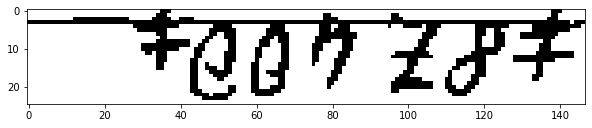

In [357]:
thresh=preprocessing(im)
rotated = imutils.rotate(thresh, 180)
plt.imshow(rotated,"gray")

In [358]:
h=thresh.shape[0]
img=rotated[10:,:]
#img=thresh[7:int(h/1.7),:]

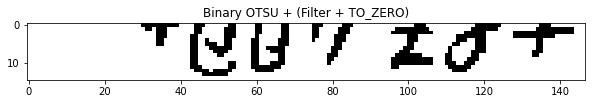

In [359]:
implt(img,'gray', 'Binary OTSU + (Filter + TO_ZERO)')

In [360]:
def vertical_projection(thresh):
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    hist=sumCols
    hist=(hist - np.amin(hist))/(np.amax(hist) - np.amin(hist))
    return hist # retourne le nombre de pixels blancs de chaque colonne de l'image binarisée


def fix_hist(hist,seuil):
    hist_=[]
    for i in range(len(hist)):
        if hist[i]<=seuil:
            hist_.append(0)
        else:
            b=hist[i]
            hist_.append(b)
    return hist_

def find_indexe(s):
    index=[]
    i=0
    while i<=len(s)-1:
        cnt_0=0
        j=0
        #if i==0 and s[i]==0:
            #index.append(cnt_0)
            #i+=1
            
        if s[i]!=0 and i<=len(s)-1:
            i+=1
        else:
            j=i-1
            while s[i]==0 and i<=len(s)-1:
                if i==len(s)-1:
                    cnt_0+=1
                    i+=1
                    break
                else:
                    cnt_0+=1
                    i+=1
            index.append(m.ceil(cnt_0/2)+j)
                
                
    return index
        

def plot_histogram(thresh,hist,indexes):
    h, w = thresh.shape
    RGBmask = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)+255 # création de fond blanc
    count=0
    for l in hist:
        cv2.line(RGBmask, (count, int(h*(l))), (count, h), color=[0,255,0], thickness=1)
        count += 1

    for i in indexes:
        cv2.circle(RGBmask, (i, int(h*hist[i])), radius=2, color=[255,0,0], thickness=-1) 
        #cv2.line(RGBmask, (i, 0), (i, h), color=[255,0,0],#thickness=1)
    implt(thresh,'gray', 'Binary OTSU + (Filter + TO_ZERO)')
    implt(RGBmask, cmp='gray', t='Final')


In [361]:

import statistics as st
def binary_graph(thresh):
    # Binary graph
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    hist=np.zeros(len(sumCols))
    #mpx=np.min(sumCols)
    mpx=0
    print(mpx)
    for pix in range(len(sumCols)):
        if sumCols[pix]>mpx:
            hist[pix]=1
        else:
            continue
    return hist
def binary_index(hist):
    # Find index
    import math as m
    indexes=find_indexe(hist)
    #print('index',ind)
    return indexes

def count_pixel(thresh):
    (h, w) = thresh.shape[:2] # h est le nombre de pixels totale par colonne et w le nombre de pixels totale par ligne
    sumCols = []
    for j in range(w):  
        col = thresh[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(h-(np.sum(col)/255))
    return sumCols # retourne le nombre de pixels blancs de chaque colonne de l'image binarisée

def plot_hist(thresh,hist):
    plt.plot(np.arange(thresh.shape[1]),vertical_projection(thresh))
    plt.plot(np.arange(thresh.shape[1]),hist)
    return 0
def peack_width(indexes):
    W=[]
    for i in range(len(indexes)-1):
        W.append(indexes[i+1]-indexes[i])
    return W   
def segment1(img, indexes):
    #pw=int(np.mean(peack_width(indexes)))
    width=img.shape[1]
    height=img.shape[0]
    rois = []
    indexes = np.insert(indexes, 0, 0)
    indexes = np.insert(indexes, len(indexes), width-1)
    print("svee: ", indexes)
    first = 0
    second = 1
    while (first < len(indexes)) and (second < len(indexes)):
        width = indexes[second] - indexes[first]
        if width <9: # paramètre de réglage
            second += 1
            continue
        roi = img[0:height, indexes[first]:indexes[first]+width]
        rois.append(roi)
        first = second
        second += 1
    plt.figure(figsize=(16, 16))
    for i in range(len(rois)):
        if rois[i].shape[1]:
            rois[i]=cv2.resize(rois[i],(28,28))
            ax = plt.subplot(1, len(rois), i+1)
            plt.imshow(rois[i], cmap='binary')
            plt.title(i, fontdict={'fontsize': 15, 'color': 'black'})
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    return rois 

0


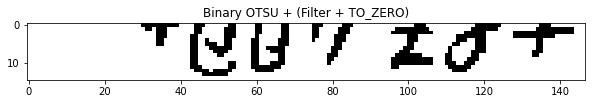

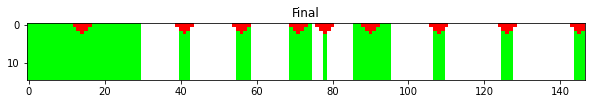

In [362]:
b=binary_graph(img)


f=binary_index(b)


plot_histogram(img,b,f)

In [363]:
f

[14, 41, 56, 71, 78, 90, 108, 126, 145]

svee:  [  0  14  41  56  71  78  90 108 126 145 146]


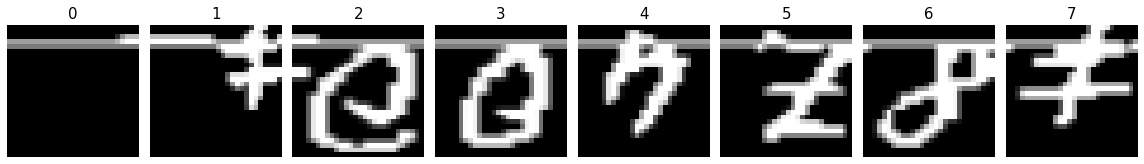

In [364]:
s=segment1(rotated,f)

In [349]:
cv2.imwrite(r"C:\Users\Obertys\Desktop\DATA HANDWRITTEN\chif.png",imutils.rotate(255-s[3],180))

True

In [350]:
img=cv2.imread(r"C:\Users\Obertys\Desktop\DATA HANDWRITTEN\chif.png")

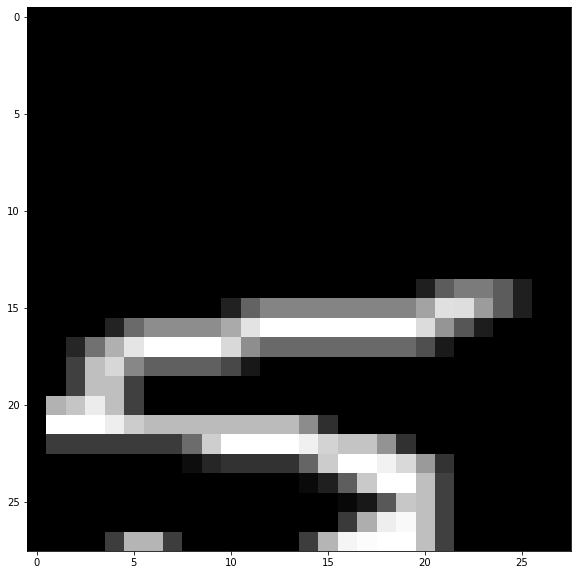

In [351]:
implt(img)